# Building `makemore` Part 2: MLP

* Lecture: [YouTube](https://youtu.be/TCH_1BHY58I)
* Reference paper: [Yoshua Bengio, Réjean Ducharme, Pascal Vincent, and Christian Jauvin. 2003. A Neural Probabilistic Language Model. J. Mach. Learn. Res. 3, (February 2003), 1137–1155.](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

One main difference in our implementation is that we are working with characters instead of words. The vocabulary size in the Bengio's paper is 17,000 words, whereas we are going to have a vocabulary of 27 characters (26 characters and the `<.>` special character).

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
words = open("./names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vacabulary of characters and mapping to/from integers
chars = sorted(list(set("".join(words))))
s2i = {s: i + 1 for i, s in enumerate(chars)}
s2i["."] = 0
i2s = {i: s for s, i in s2i.items()}
vocab_size = len(i2s)
print(i2s)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
block_size = 3  # context length


def build_dataset(words):
    x, y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = s2i[ch]
            x.append(context)
            y.append(ix)
            context = context[1:] + [ix]  # crop and append

    x = torch.tensor(x)
    y = torch.tensor(y)
    print(x.shape, y.shape)
    return x, y


import random

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

x_trn, y_trn = build_dataset(words[:n1])
x_val, y_val = build_dataset(words[n1:n2])
x_tst, y_tst = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
# MLP
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn((n_hidden), generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn((vocab_size), generator=g)

parameters = [C, W1, b1, W2, b2]
print(
    f"Number of trainable parameters: {sum(p.nelement() for p in parameters)}"
)  # total number of parameters in the model

for p in parameters:
    p.requires_grad = True

Number of trainable parameters: 11897


How can we find a good startint point for the learning rate?

In [7]:
lre = []
lrs = []
tracker = []
max_steps = 1_000
bs = 32

for e in torch.linspace(-3, 0, max_steps):
    lrs.append(10**e)
    lre.append(e)

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, x_trn.shape[0], (bs,), generator=g)
    xb = x_trn[ix]
    yb = y_trn[ix]

    # forward pass
    emb = C[xb]  # embed the characters into vectors
    emb_cat = emb.view((emb.shape[0], -1))  # concat the vectors
    h_pre_act = emb_cat @ W1 + b1  # hidden layer pre-activation
    h = torch.tanh(h_pre_act)  # hidden layer
    logits = h @ W2 + b2  # output layer
    loss = F.cross_entropy(logits, yb)  # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    with torch.no_grad():
        for p in parameters:
            p -= lrs[i] * p.grad

    # track stats
    tracker.append(loss.item())

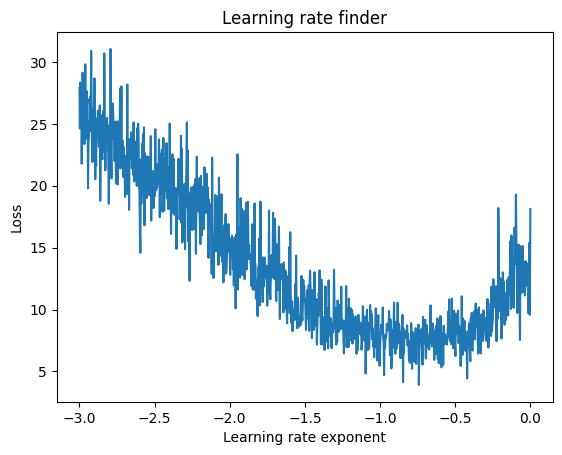

In [8]:
plt.plot(lre, tracker)
plt.title("Learning rate finder")
plt.ylabel("Loss")
plt.xlabel("Learning rate exponent")
plt.show()

Using the LR Finder first proposed by [Leslie Smith](https://arxiv.org/abs/1506.01186), $ 10^{-1} $ seems like a good starting point.

In [9]:
# re-init the model
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn((n_hidden), generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn((vocab_size), generator=g)

parameters = [C, W1, b1, W2, b2]
print(
    f"Number of trainable parameters: {sum(p.nelement() for p in parameters)}"
)  # total number of parameters in the model

for p in parameters:
    p.requires_grad = True

Number of trainable parameters: 11897


In [10]:
max_steps = 200_000
bs = 32
lr = 0.1  # 1e-1

steps = []
lrs = []
loss_i = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, x_trn.shape[0], (bs,), generator=g)
    xb = x_trn[ix]
    yb = y_trn[ix]

    # forward pass
    emb = C[xb]  # embed the characters into vectors
    emb_cat = emb.view((emb.shape[0], -1))  # concat the vectors
    h_pre_act = emb_cat @ W1 + b1  # hidden layer pre-activation
    h = torch.tanh(h_pre_act)  # hidden layer
    logits = h @ W2 + b2  # output layer
    loss = F.cross_entropy(logits, yb)  # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    if i == 100_000:
        old_lr = lr
        lr /= 10
        print(f"step: {i} // old lr: {old_lr} ---> new lr: {lr}")
    with torch.no_grad():
        for p in parameters:
            p -= lr * p.grad

    # track stats
    if i % 10_000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    loss_i.append(loss.log10().item())

      0/ 200000: 27.8817
  10000/ 200000: 2.9417
  20000/ 200000: 2.5795
  30000/ 200000: 2.7819
  40000/ 200000: 2.0216
  50000/ 200000: 2.5858
  60000/ 200000: 2.3217
  70000/ 200000: 2.1007
  80000/ 200000: 2.2893
  90000/ 200000: 2.2368
step: 100000 // old lr: 0.1 ---> new lr: 0.01
 100000/ 200000: 1.9774
 110000/ 200000: 2.4507
 120000/ 200000: 1.9623
 130000/ 200000: 2.3657
 140000/ 200000: 2.2424
 150000/ 200000: 2.1469
 160000/ 200000: 2.2506
 170000/ 200000: 1.7543
 180000/ 200000: 2.1055
 190000/ 200000: 1.8174


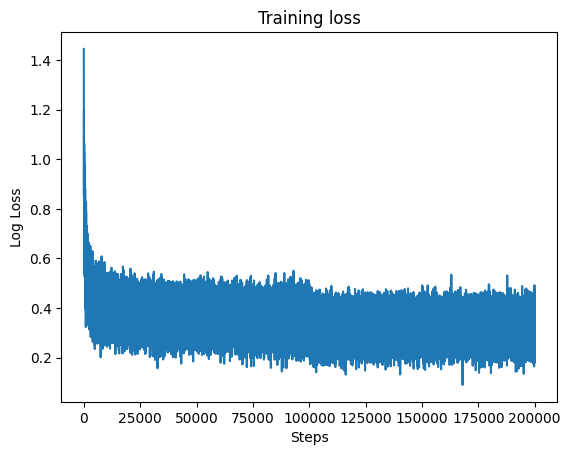

In [11]:
plt.plot(loss_i)
plt.title("Training loss")
plt.xlabel("Steps")
plt.ylabel("Log Loss")
plt.show()

In [12]:
@torch.no_grad()  # this decorator disable gradient tracking
def split_loss(split: str):
    x, y = {
        "train": (x_trn, y_trn),
        "val": (x_val, y_val),
        "test": (x_tst, y_tst),
    }[split]
    emb = C[x]  # (bs, block_size, n_embd)
    emb_cat = emb.view((emb.shape[0], -1))  # concat into (bs, block_size * n_embd)
    h_pre_act = emb_cat @ W1 + b1  # (bs, n_hidden)
    h = torch.tanh(h_pre_act)  # (bs, n_hidden)
    logits = h @ W2 + b2  # (bs, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss("train")
split_loss("val")

train 2.126697540283203
val 2.171041250228882


Let's validate the quality of our model on the validation set.

In [13]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)
block_size = 3
for _ in range(20):
    out = []
    context = [0] * block_size  # initialize with all ...
    while True:
        # forward pass of the neural network
        emb = C[torch.tensor([context])]  # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if the special "." token break
        if ix == 0:
            break

    print("".join(i2s[i] for i in out))

mona.
mayah.
see.
mel.
ryllo.
emmadiengramira.
eredielin.
shy.
jen.
eden.
eson.
arleiyah.
hone.
cayshubergihimier.
kendreelynn.
nochorius.
macder.
yaque.
ehs.
kayjahsin.


This generated names are better than those generated by the bigram model, although not that good yet.